# WaveNet Sample Generation
Fast generation of samples from a pretrained WaveNet model

In [1]:
from model import Optimizer, WaveNetData
from WaveNetModel2 import WaveNetModel2

import torch
import numpy as np
import time

from IPython.display import Audio
from matplotlib import pyplot as plt
from matplotlib import pylab as pl
from IPython import display

%matplotlib notebook

## Load Model

In [2]:
train_sample = "train_samples/bach_full.wav"
parameters = "model_parameters/bach_10-5-256-32-32-256-2"
layers = 10
blocks = 5
classes = 256
dilation_channels = 32
residual_channels = 32
skip_channels = 256
kernel_size = 2

use_cuda = torch.cuda.is_available()

In [3]:
model = WaveNetModel2(layers=layers,
                      blocks=blocks,
                      dilation_channels=dilation_channels,
                      residual_channels=residual_channels,
                      skip_channels=skip_channels,
                      classes=classes)

if use_cuda:
    model.cuda()
    print("use cuda")

#print("model: ", model)
print("scope: ", model.scope)

if use_cuda:
    model.load_state_dict(torch.load(parameters))
else:
    model.load_state_dict(torch.load(parameters, map_location=lambda storage, loc: storage))

data = WaveNetData(train_sample,
                   input_length=model.scope,
                   target_length=model.last_block_scope,
                   num_classes=model.classes,
                   cuda=use_cuda)

scope:  5627


In [4]:
def print_par_count():
    import pdb; pdb.set_trace()
    p_count = model.parameter_count()
    print(p_count)
    
print_par_count()

> <ipython-input-4-9db5f023475a>(3)print_par_count()
-> p_count = model.parameter_count()
(Pdb) q


BdbQuit: 

<IPython.core.display.Javascript object>


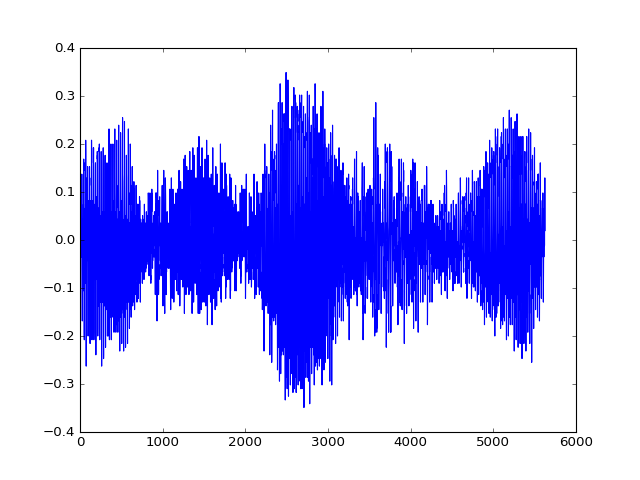

In [5]:
start_data = data.get_minibatch([model.scope+15000])[0].squeeze()
#start_tensor = torch.zeros((model.scope)) + 0.0

plt.plot(start_data.numpy())

## Generate Samples


In [6]:
num_samples = 11025 # number of samples that will be generated
sample_rate = 11025
out_file = "generated_samples/bach_10-5-256-32-32-256-2.wav"

<IPython.core.display.Javascript object>


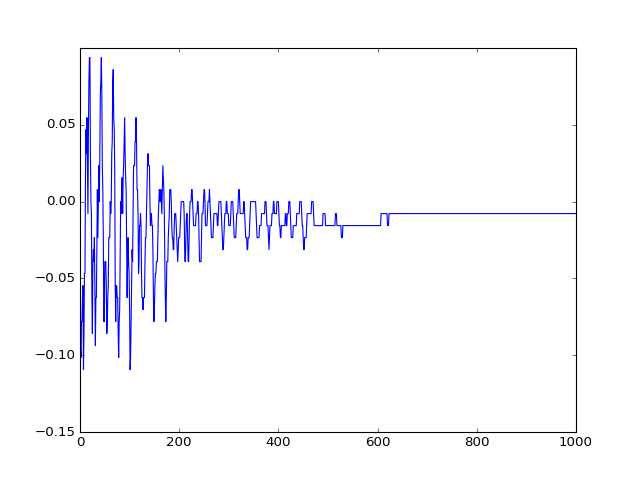

In [12]:
from ipywidgets import FloatProgress
from IPython.display import display
progress = FloatProgress(min=0, max=100)
display(progress)

def p_callback(i, total):
    progress.value += 1

tic = time.time()
generated_sample = model.generate_fast(num_samples, 
                                       #first_samples=start_data,
                                       first_samples=torch.zeros((1)),
                                       progress_callback=p_callback,
                                       sampled_generation=False,
                                       temperature=1.0)
toc = time.time()
print('Generating took {} seconds.'.format(toc-tic))

> /Users/vincentherrmann/Documents/Software/PyTorch/WaveNet/WaveNetModel2.py(181)generate_fast()
-> num_given_samples = first_samples.size(0)
(Pdb) c
Generating took 174.62227296829224 seconds.


<IPython.core.display.Javascript object>


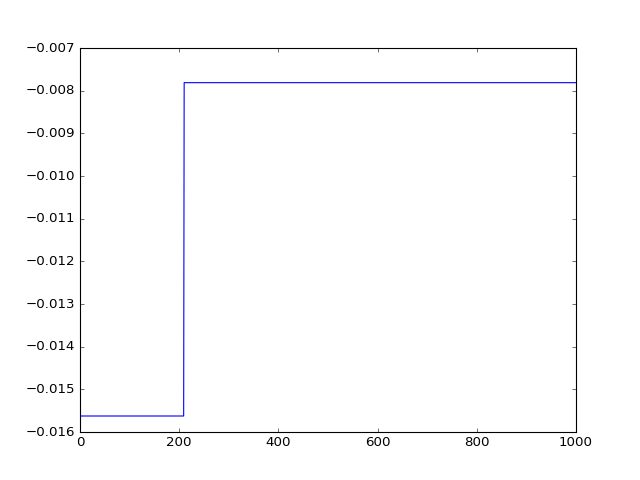

In [13]:
fig = plt.figure()
plt.plot(generated_sample[0:1000])

from IPython.display import Audio
Audio(np.array(generated_sample), rate=sample_rate)

In [9]:
print(np.array(generated_sample))

from scipy.io import wavfile
wavfile.write(out_file, sample_rate, np.array(generated_sample))

[-0.0234375 -0.1015625 -0.0859375 ..., -0.0078125 -0.0078125 -0.0078125]
